# Purpose

Use `meshio` to write time series data to xdmf file. See **Time series** at [meshio](https://pypi.org/project/meshio/).

# Imports

In [1]:
from math import ceil
from typing import Iterator, Tuple

import numpy as np
from scipy.sparse.linalg import splu

import skfem
# from skfem import *
from skfem.models.poisson import laplace, mass

import meshio

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from skfem.visuals.matplotlib import plot

# Code

In [2]:
def points_and_cells(mesh):
    if mesh.t.shape[0] == 4:
        cell_type = "quad"
    elif mesh.t.shape[0] == 3:
        cell_type = "triangle"
    elif mesh.t.shape[0] == 2:
        cell_type = "line"
    else:
        raise ValueError(f"Number of cell nodes is {mesh.t.shape[0]}, must be in range 2 to 4 for 2D mesh")

    cells = []
    for i in range(mesh.t.shape[1]):
        cells.append([index for index in mesh.t[:, i]])
    
    return mesh.p, np.array(cells)

def add_z_coordinate(points_2D):
    return np.vstack((points_2D, np.zeros(points_2D.shape[1])))

# Mesh with quad cells

## Mesh

<skfem MeshQuad1 object>
  Number of elements: 16
  Number of vertices: 25
  Number of nodes: 25
  Named boundaries [# facets]: left [4], bottom [4], right [4], top [4]


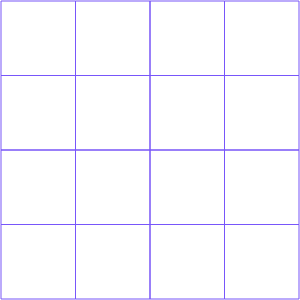

In [3]:
mesh_quad = skfem.MeshQuad().refined(2)
print(mesh_quad)
mesh_quad

In [4]:
points_and_cells(mesh_quad)

(array([[0.  , 1.  , 1.  , 0.  , 0.5 , 0.  , 1.  , 0.5 , 0.5 , 0.25, 0.  ,
         0.75, 1.  , 1.  , 0.75, 0.  , 0.25, 0.5 , 0.25, 0.75, 0.5 , 0.25,
         0.75, 0.75, 0.25],
        [0.  , 0.  , 1.  , 1.  , 0.  , 0.5 , 0.5 , 1.  , 0.5 , 0.  , 0.25,
         0.  , 0.25, 0.75, 1.  , 0.75, 1.  , 0.25, 0.5 , 0.5 , 0.75, 0.25,
         0.25, 0.75, 0.75]]),
 array([[ 0,  9, 21, 10],
        [ 4, 11, 22, 17],
        [ 8, 19, 23, 20],
        [ 5, 18, 24, 15],
        [ 9,  4, 17, 21],
        [11,  1, 12, 22],
        [19,  6, 13, 23],
        [18,  8, 20, 24],
        [21, 17,  8, 18],
        [22, 12,  6, 19],
        [23, 13,  2, 14],
        [24, 20,  7, 16],
        [10, 21, 18,  5],
        [17, 22, 19,  8],
        [20, 23, 14,  7],
        [15, 24, 16,  3]]))

In [5]:
mesh_quad.t.shape

(4, 16)

## Basis

In [6]:
basis_quad = skfem.Basis(mesh_quad, skfem.ElementQuad2())
print(basis_quad)

<skfem CellBasis(MeshQuad1, ElementQuad2) object>
  Number of elements: 16
  Number of DOFs: 81
  Size: 86400 B


## Create array to hold data values

In [7]:
values_quad = basis_quad.zeros()
values_quad.shape

(81,)

### Initialize with arbitrary data

In [8]:
values_quad[0] = 2
values_quad[1] = 1.5
values_quad[7] = 1
values_quad[10] = -1

## Write simple VTK file

In [9]:
points, cells = points_and_cells(mesh_quad)
points = add_z_coordinate(points).T

meshio.write_points_cells(
    "xdmf_write_time_series_quad.vtk", 
    points, 
    [("quad", cells)], 
    point_data={"values": values_quad[:mesh_quad.nvertices]}
)

## Write time series XDMF file

In [10]:
times = [0.0, 1.0, 2.0, 3.0]
points, cells = points_and_cells(mesh_quad)
points = add_z_coordinate(points).T

with meshio.xdmf.TimeSeriesWriter("xdmf_write_time_series_quad.xdmf") as writer:
    writer.write_points_cells(points, [("quad", cells)])
    for t in times:
        values_quad[3] = t
        writer.write_data(t, point_data={"solution": values_quad[:mesh_quad.nvertices]})

# Mesh with triangle cells

<skfem MeshTri1 object>
  Number of elements: 32
  Number of vertices: 25
  Number of nodes: 25
  Named boundaries [# facets]: left [4], bottom [4], right [4], top [4]


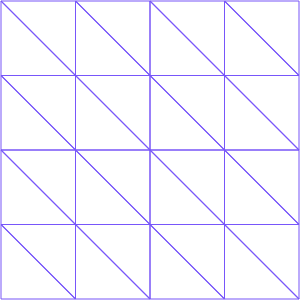

In [11]:
mesh_tri = mesh = skfem.MeshTri().refined(2)
print(mesh_tri)
mesh_tri

## Basis

In [12]:
basis_tri = skfem.Basis(mesh_tri, skfem.ElementTriP1())
print(basis_tri)

<skfem CellBasis(MeshTri1, ElementTriP1) object>
  Number of elements: 32
  Number of DOFs: 25
  Size: 6912 B


## Create array to hold data values

In [13]:
values_tri = basis_tri.zeros()
values_tri.shape

(25,)

### Initialize with arbitrary data

In [14]:
values_tri[0] = 2
values_tri[1] = 1.5
values_tri[7] = 1
values_tri[10] = -1

## Write simple VTK file

In [15]:
points, cells = points_and_cells(mesh_tri)
points = add_z_coordinate(points).T

meshio.write_points_cells(
    "xdmf_write_time_series_tri.vtk", 
    points, 
    [("triangle", cells)], 
    point_data={"values": values_tri[:mesh_tri.nvertices]}
)

## Write time series XDMF file

In [16]:
times = [0.0, 1.0, 2.0, 3.0]
points, cells = points_and_cells(mesh_tri)
points = add_z_coordinate(points).T

with meshio.xdmf.TimeSeriesWriter("xdmf_write_time_series_tri.xdmf") as writer:
    writer.write_points_cells(points, [("triangle", cells)])
    for t in times:
        values_tri[3] = t
        writer.write_data(t, point_data={"solution": values_tri[:mesh_tri.nvertices]})